In [111]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, LayerNormalization, Dropout
from keras.models import Model

from PAK import evaluate

In [2]:
try:
    # enable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type == 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Data Loading

In [3]:
# Set the directories
DATA_DIR_SLOW = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaSlow.npy"
DATA_DIR_NORMAL = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaNormal.npy"
DATA_DIR_C_NAMES = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/KukaVelocityDataset/KukaColumnNames.npy"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [90]:
# Load the files
data_normal = np.load(DATA_DIR_NORMAL)
data_slow = np.load(DATA_DIR_SLOW)
column_names = np.load(DATA_DIR_C_NAMES)

In [91]:
# Check the column names
print(column_names)

['action' 'machine_nameKuka Robot_apparent_power'
 'machine_nameKuka Robot_current' 'machine_nameKuka Robot_frequency'
 'machine_nameKuka Robot_phase_angle' 'machine_nameKuka Robot_power'
 'machine_nameKuka Robot_power_factor'
 'machine_nameKuka Robot_reactive_power' 'machine_nameKuka Robot_voltage'
 'sensor_id1_AccX' 'sensor_id1_AccY' 'sensor_id1_AccZ' 'sensor_id1_GyroX'
 'sensor_id1_GyroY' 'sensor_id1_GyroZ' 'sensor_id1_q1' 'sensor_id1_q2'
 'sensor_id1_q3' 'sensor_id1_q4' 'sensor_id1_temp' 'sensor_id2_AccX'
 'sensor_id2_AccY' 'sensor_id2_AccZ' 'sensor_id2_GyroX' 'sensor_id2_GyroY'
 'sensor_id2_GyroZ' 'sensor_id2_q1' 'sensor_id2_q2' 'sensor_id2_q3'
 'sensor_id2_q4' 'sensor_id2_temp' 'sensor_id3_AccX' 'sensor_id3_AccY'
 'sensor_id3_AccZ' 'sensor_id3_GyroX' 'sensor_id3_GyroY'
 'sensor_id3_GyroZ' 'sensor_id3_q1' 'sensor_id3_q2' 'sensor_id3_q3'
 'sensor_id3_q4' 'sensor_id3_temp' 'sensor_id4_AccX' 'sensor_id4_AccY'
 'sensor_id4_AccZ' 'sensor_id4_GyroX' 'sensor_id4_GyroY'
 'sensor_id4_GyroZ

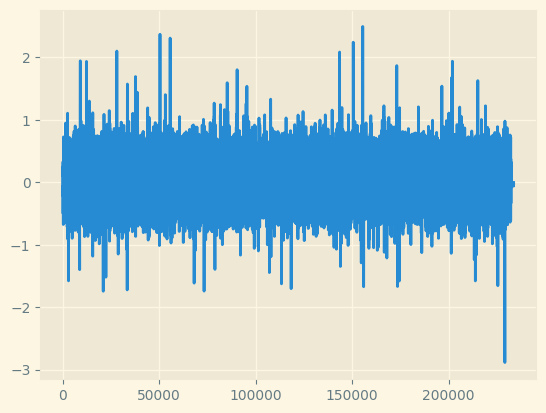

In [6]:
# data_slow one sensor
signal = data_normal[:,31]
t = [i for i in range(data_normal.shape[0])]
plt.figure(1)
plt.plot(t, signal)

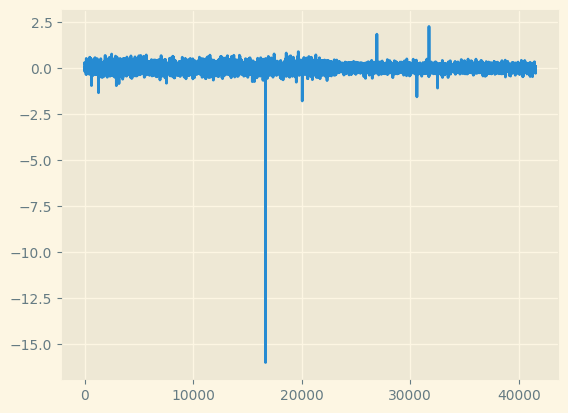

In [7]:
# data_slow one sensor
signal = data_slow[:,31]
t = [i for i in range(data_slow.shape[0])]
plt.figure(1)
plt.plot(t, signal)

## Data Setup

In [92]:
# slow data label preparation by extracting (all 1)
label_slow = data_slow[:,-1:]
data_slow = data_slow[:,:-1] # drop the last colum because it is just 1 that represents anomaly "true"

In [93]:
# Find the features that have less variable values than given threshold
threshold = 31
unique = {}
for i in range(data_normal.shape[1]):
    classes = np.unique(data_normal[:,i])
    if len(classes) < threshold:
        unique[i] = [len(classes) , classes]
print(unique, len(unique))
delete_list = []
for i in range(data_normal.shape[1]):
    if i not in unique.keys():
        delete_list.append(False)
    else:
        delete_list.append(True)

{3: [5, array([49.902534, 49.951218, 50.      , 50.048878, 50.097847])], 30: [1, array([144.12])], 41: [2, array([120.3 , 144.12])], 52: [3, array([-175.86,    9.59,  144.12])], 63: [1, array([144.12])], 74: [1, array([180.24])], 85: [1, array([180.24])]} 7


In [94]:
# Take the features less variable than given threshold
data_normal_dr = np.delete(data_normal, delete_list, axis=1)
data_slow_dr = np.delete(data_slow, delete_list, axis=1)
print(f"Shape of slow data after basic feature selection: {data_slow_dr.shape} \nFor normal data: {data_normal_dr.shape}")

Shape of slow data after basic feature selection: (41538, 79) 
For normal data: (233792, 79)


## AE-SAD Label Preparation

The temporary anomalies (abnormal readings) is labeled to considered as anomalies in the training phase. For this, the least occurred X percent readings will be labeled as anomaly. X is prior information that decided with consideration of training data quality.

In [95]:
def threshold(data, percent):
    try:
        pc_p = np.percentile(data[data > 0], percent)
        pc_n = np.percentile(np.abs(data[data < 0]), percent)
    except:
        pc_p, pc_n = 0 , 0
    return pc_p, -pc_n

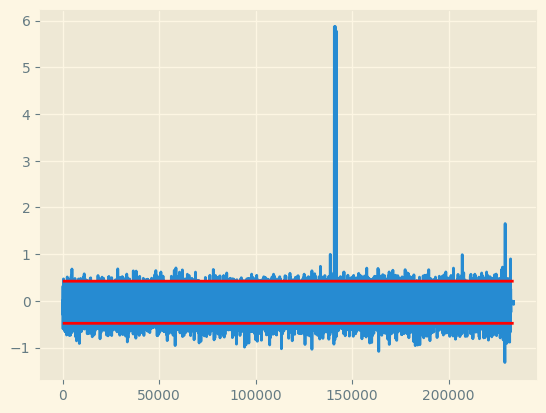

In [96]:
# data_slow one sensor
feature = 30

signal = data_normal_dr[:,feature]
t = [i for i in range(data_normal_dr.shape[0])]
pc_p, pc_n = threshold(data_normal_dr[:,feature], 99)
sd_p = [pc_p for i in range(data_normal_dr.shape[0])]
sd_n = [pc_n for i in range(data_normal_dr.shape[0])]
plt.figure(1)
plt.plot(t, signal)
plt.plot(t, sd_p, c="red")
plt.plot(t, sd_n, c="red")

In [97]:
final_labels = []
for feature in range(data_normal_dr.shape[1]):
    th_p, th_n = threshold(data_normal_dr[:, feature], 99.9)
    is_anomaly_p = data_normal_dr[:,feature]>th_p
    is_anomaly_n = data_normal_dr[:,feature]<th_n
    if len(final_labels) == 0 and th_p!=0:
        final_labels = np.array(is_anomaly_p)
        final_labels = final_labels | np.array(is_anomaly_n)
    elif th_p!=0:
        final_labels = final_labels | np.array(is_anomaly_p)
        final_labels = final_labels | np.array(is_anomaly_n)

final_labels = [int(i) for i in final_labels]
print(f"total anomaly: {sum(final_labels)}, label length: {len(final_labels)}")

total anomaly: 12641, label length: 233792


In [98]:
# Normalization train on train set transform both
scaler = preprocessing.StandardScaler().fit(data_normal_dr)
data_train_scaled = scaler.transform(data_normal_dr)
data_test_scaled = scaler.transform(data_slow_dr)

In [99]:
#windows of 48 with stride 1
width_window = 48
data_train_all = np.array([data_train_scaled[i:i+width_window,:] for i in range(0, len(data_train_scaled)-width_window)])
data_test_all = np.array([data_test_scaled[i:i+width_window,:] for i in range(0, len(data_test_scaled)-width_window)])

final_labels = final_labels[0: len(data_train_scaled)-width_window]
print(f"train data shape: {data_train_all.shape} \ntest data shape: {data_test_all.shape} \n train label size: {len(final_labels)}")

train data shape: (233744, 48, 79) 
test data shape: (41490, 48, 79) 
 train label size: 233744


In [139]:
# Shuffle the data
mix_data = True
seed = 0
if mix_data:
    data_train_all = tf.random.shuffle(data_train_all, seed=seed)
    final_labels = tf.random.shuffle(final_labels, seed=seed)

    data_test_all = tf.random.shuffle(data_test_all, seed=seed)
print(f"train data shape: {data_train_all.shape} \ntrain label size: {len(final_labels)}")

train data shape: (233744, 48, 79) 
train label size: 233744


In [165]:
# First 60 percent for training, 20 percent for validation between 60-80, 20 percent for test from 80-100
percentage_train = 0.6
# percentage_test = 0.05
# validation = [0.79, 0.80]
percentage_test = 1.
validation = [0.60, 0.80]
test = 0.80

# take part of data to gather results faster
data_train = data_train_all[0:int(percentage_train*data_train_all.shape[0]),:,:]
data_test = data_test_all[0:int(percentage_test*data_test_all.shape[0]),:,:]

# training labels for AE_SAD
y_train = final_labels[0:int(percentage_train*data_train_all.shape[0])]

# mixed test data 50-50
data_test_mixed = np.zeros((2*data_test.shape[0], data_test.shape[1], data_test.shape[2]))
data_test_mixed[0:int(data_test.shape[0]),:,:] += data_test
data_test_mixed[int(data_test.shape[0]):,:,:] += data_train_all[int(test*data_train_all.shape[0]): int(test*data_train_all.shape[0])+data_test.shape[0],:,:]

# set labels
label_test = label_slow[0:data_test.shape[0]]
label_test_mixed = np.zeros((data_test_mixed.shape[0], 1))
label_test_mixed[0:label_test.shape[0]] += label_test

# Validation data
data_validation = data_train_all[int(validation[0]*data_train_all.shape[0]): int(validation[1]*data_train_all.shape[0]),:,:]


print(f"train data shape: {data_train.shape}, train label size: {len(y_train)} \ntest data shape: {data_test.shape} \nlabel shape: {label_test.shape} \n\ntest data prepared: {data_test_mixed.shape} \nlabel prepared: {label_test_mixed.shape} \n\ndata validation: {data_validation.shape}")

train data shape: (140246, 48, 79), train label size: 140246 
test data shape: (41490, 48, 79) 
label shape: (41490, 1) 

test data prepared: (82980, 48, 79) 
label prepared: (82980, 1) 

data validation: (46749, 48, 79)


## Model

In [149]:
# set these variables before model creation
input_shape = data_train.shape[1:]
n_features = data_train.shape[2]
latent_size = 10
dropout = False
layer_norm = True

In [150]:
# Autoencoder class
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x, **kwargs):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Encoder, Decoder, Discriminator functions
def build_model_enc():
    model = Sequential()
    model.add(LSTM(latent_size*16, activation='relu', input_shape=input_shape, return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size, activation='relu', return_sequences=False))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(RepeatVector(width_window))
    return model

def build_model_dec():
    model = Sequential()

    model.add(LSTM(latent_size, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*2, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*4, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*8, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(LSTM(latent_size*16, activation='relu', return_sequences=True))
    if layer_norm : model.add(LayerNormalization())
    if dropout : model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(units=n_features)))
    return model

In [151]:
mse = tf.keras.losses.MeanSquaredError()

# Loss functions for autoencoder, discriminator and generator
def autoencoder_loss(inputs, reconstruction, labels, loss_weight):
    weighted_mse_loss = mse(inputs[labels==0], reconstruction[labels==0]) + (loss_weight * mse(inputs[labels==1], reconstruction[labels==1]))
    return weighted_mse_loss

In [152]:
# Train function for optimizing gradients for each batch
comment = False
def train_step(batch_x, batch_y):
    with tf.device(current_device):
        # -------------------------------------------------------------------------------------------------------------
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            encoded = model.encoder(batch_x, training=True)
            decoded = model.decoder(encoded, training=True)

            if comment is True : print(f"Train step: \nbatch_x: {batch_x.shape}, decoded: {decoded.shape}")
            # Autoencoder loss
            ae_loss = autoencoder_loss(batch_x, decoded, batch_y, lambda_SAD)

        ae_grads = ae_tape.gradient(ae_loss, model.encoder.trainable_variables + model.decoder.trainable_variables)
        optimizer.apply_gradients(zip(ae_grads, model.encoder.trainable_variables + model.decoder.trainable_variables))

    return ae_loss


In [160]:
# Device selection
current_device = 'GPU'

# Build autoencoder
encoder = build_model_enc()
decoder = build_model_dec()

model = Autoencoder(encoder, decoder, width_window)
model.build(input_shape=(None, input_shape[0], input_shape[1]))

# learning rate, optimizer and summary
lambda_SAD = 0.1
learning_rate = 1e-4
batch_size = 256
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "autoencoder_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 48, 10)            256820    
                                                                 
 sequential_33 (Sequential)  (None, 48, 79)            219379    
                                                                 
Total params: 476,199
Trainable params: 476,199
Non-trainable params: 0
_________________________________________________________________


In [161]:
# split to data to batches
with tf.device(current_device):
    train_dataset = tf.data.Dataset.from_tensor_slices(data_train)
    train_dataset = train_dataset.batch(batch_size)

    train_labelset = tf.data.Dataset.from_tensor_slices(y_train)
    train_labelset = train_labelset.batch(batch_size)

# And training phase
n_epochs = 50
train_autoencoder_loss = []


# if validation information needed (it takes more time for training)
test_cost = []
validation_cost = []


# keep the best loss of autoencoder
last_best = 9
last_loss = 10
last_epoch = 0
shape = F"{latent_size}_5_layer_AAE_SAD_1e4"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{n_epochs}_{shape}"

# Create directory for model weights
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
print(f"Weights will be saved in: {model_dir}")

for epoch in range(n_epochs):
    epoch += last_epoch
    start = time.time()

    # Save the best model
    if epoch > 1 and (last_best>last_loss):
        best_path = f"{model_dir}/best"
        if not os.path.exists(best_path):
            os.mkdir(best_path)
            os.mkdir(f"{best_path}/AE")

        # Save the weight for future test and further training
        model.save_weights(f"{best_path}/AE/model")

        print(f"Saved! AE loss has been decreased from {last_best} to {epoch_ae_loss_avg.result()}.")
        last_best = epoch_ae_loss_avg.result()


    # Save every 5 epoch
    elif epoch > 1 and epoch%5==0:
        epoch_path = f"{model_dir}/{epoch+1}"
        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)
            os.mkdir(f"{epoch_path}/AE")

        # Save the weight for future test and further training
        model.save_weights(f"{epoch_path}/AE/model")

        print(f"Saved!")


    # average loss calculator for batches
    epoch_ae_loss_avg = tf.metrics.Mean()
    for batch, (batch_x, batch_y) in enumerate(zip(train_dataset, train_labelset)):
        # -------------------------------------------------------------------------------------------------------------
    # Calculate the losses and optimize them
        ae_loss = train_step(batch_x, batch_y)

        epoch_ae_loss_avg(ae_loss)


    # Some feedback information
    last_loss = epoch_ae_loss_avg.result()
    epoch_time = time.time() - start
    print(
        '{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f}'
        .format(epoch + 1 , epoch_time / 60,
                epoch_time * (n_epochs - epoch) / 60,
                epoch_ae_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())

    # Validation information
    # -------------------------------------------------------------------------------------------------------------
    # train_decoded = model_ae.predict(data_train)
    # cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    # train_cost.append(cost_train)
    # print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")
    #
    test_decoded = model.predict(data_test)
    cost_test = np.mean(np.square(np.abs(test_decoded - data_test)))
    test_cost.append(cost_test)
    print(f"        MSE of test: {np.mean(np.abs(test_decoded - data_test))}")
    #
    val_decoded = model.predict(data_validation)
    cost_val = np.mean(np.square(np.abs(val_decoded - data_validation)))
    validation_cost.append(cost_val)
    print(f"        MSE of validation: {np.mean(np.abs(val_decoded - data_validation))}")

Weights will be saved in: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/50_10_5_layer_AAE_SAD_1e4
   1: TIME: 7.70 ETA: 384.88 AE_LOSS: 1.1415
65/65 [==============================] - 3s 40ms/step
        MSE of test: 0.6114290292342509
74/74 [==============================] - 3s 41ms/step
        MSE of validation: 0.6533770511940195
   2: TIME: 7.67 ETA: 375.72 AE_LOSS: 1.0071
65/65 [==============================] - 3s 42ms/step
        MSE of test: 0.6057463032787634
74/74 [==============================] - 3s 41ms/step
        MSE of validation: 0.6438566105435628
Saved! AE loss has been decreased from 9 to 1.0070961713790894.
   3: TIME: 7.67 ETA: 368.01 AE_LOSS: 0.9817
65/65 [==============================] - 3s 42ms/step
        MSE of test: 0.601581818971865
74/74 [==============================] - 3s 41ms/step
        MSE of validation: 0.6307663850053181
Saved! AE loss has been decreased from 1.0070961713790894 to 0.9817099571228027.
   4: TIME:

In [162]:
# And training phase
n_epochs = 100

# keep the best loss of autoencoder
last_best = 9
last_loss = 10
last_epoch = 50
shape = F"{latent_size}_5_layer_AAE_SAD_1e4"
checkpoint_dir = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints"
model_dir = f"{checkpoint_dir}/{n_epochs}_{shape}"

# Create directory for model weights
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
print(f"Weights will be saved in: {model_dir}")

for epoch in range(n_epochs):
    epoch += last_epoch
    start = time.time()

    # Save the best model
    if epoch > 1 and (last_best>last_loss):
        best_path = f"{model_dir}/best"
        if not os.path.exists(best_path):
            os.mkdir(best_path)

        # Save the weight for future test and further training
        model.save_weights(f"{best_path}/model")

        print(f"Saved! AE loss has been decreased from {last_best} to {epoch_ae_loss_avg.result()}.")
        last_best = epoch_ae_loss_avg.result()


    # Save every 5 epoch
    elif epoch > 1 and epoch%5==0:
        epoch_path = f"{model_dir}/{epoch+1}"
        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)

        # Save the weight for future test and further training
        model.save_weights(f"{epoch_path}/model")

        print(f"Saved!")


    # average loss calculator for batches
    epoch_ae_loss_avg = tf.metrics.Mean()
    for batch, (batch_x, batch_y) in enumerate(zip(train_dataset, train_labelset)):
        # -------------------------------------------------------------------------------------------------------------
    # Calculate the losses and optimize them
        ae_loss = train_step(batch_x, batch_y)

        epoch_ae_loss_avg(ae_loss)


    # Some feedback information
    last_loss = epoch_ae_loss_avg.result()
    epoch_time = time.time() - start
    print(
        '{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f}'
        .format(epoch + 1 , epoch_time / 60,
                epoch_time * (n_epochs - epoch) / 60,
                epoch_ae_loss_avg.result()))
    train_autoencoder_loss.append(epoch_ae_loss_avg.result())

    # Validation information
    # -------------------------------------------------------------------------------------------------------------
    # train_decoded = model_ae.predict(data_train)
    # cost_train = np.mean(np.abs(train_decoded - data_train), axis=1)
    # train_cost.append(cost_train)
    # print(f"        Mean cost of train: {np.mean(np.abs(train_decoded - data_train))}")
    #
    test_decoded = model.predict(data_test)
    cost_test = np.mean(np.square(np.abs(test_decoded - data_test)))
    test_cost.append(cost_test)
    print(f"        MSE of test: {np.mean(np.abs(test_decoded - data_test))}")
    #
    val_decoded = model.predict(data_validation)
    cost_val = np.mean(np.square(np.abs(val_decoded - data_validation)))
    validation_cost.append(cost_val)
    print(f"        MSE of validation: {np.mean(np.abs(val_decoded - data_validation))}")

Weights will be saved in: /Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/100_10_5_layer_AAE_SAD_1e4
Saved!
  51: TIME: 7.68 ETA: 384.24 AE_LOSS: 0.5062
65/65 [==============================] - 3s 43ms/step
        MSE of test: 0.5292663320090549
74/74 [==============================] - 3s 43ms/step
        MSE of validation: 0.38800235393362825
Saved! AE loss has been decreased from 9 to 0.5062471628189087.
  52: TIME: 7.68 ETA: 376.34 AE_LOSS: 0.5010
65/65 [==============================] - 3s 43ms/step
        MSE of test: 0.529905000424714
74/74 [==============================] - 3s 42ms/step
        MSE of validation: 0.3860494419434704
Saved! AE loss has been decreased from 0.5062471628189087 to 0.5010218024253845.
  53: TIME: 7.65 ETA: 367.44 AE_LOSS: 0.4961
65/65 [==============================] - 3s 42ms/step
        MSE of test: 0.5299135169254805
74/74 [==============================] - 3s 42ms/step
        MSE of validation: 0.381702503078294
Sav

KeyboardInterrupt: 

In [167]:
# Load best weights
path = "/Users/kedi/Desktop/polito lectures and notes/ML in App/project/checkpoints/100_10_5_layer_AAE_SAD_1e4/best"
model.load_weights(f"{path}/model")

In [163]:
# save the loss changes
np.save(f"{model_dir}/train_loss.npy", train_autoencoder_loss)
np.save(f"{model_dir}/test_loss.npy", test_cost)
np.save(f"{model_dir}/val_loss.npy", validation_cost)

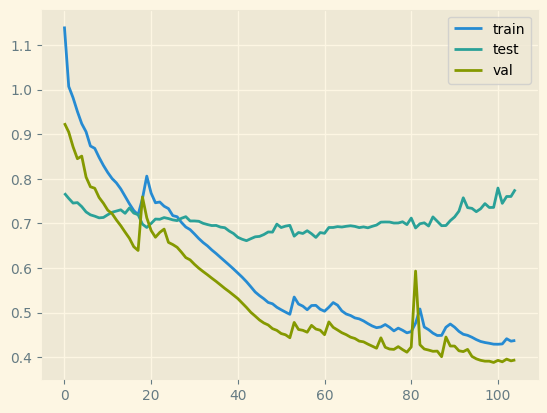

In [164]:
# Losses during training
plt.plot(train_autoencoder_loss, label="train")
plt.plot(test_cost, label="test")
plt.plot(validation_cost, label="val")
plt.legend()
plt.show()

In [168]:
# some results with average reconstruction cost
p_train = model.predict(data_train)
difference_train = np.abs(p_train - data_train)
cost_train = np.mean(np.abs(p_train - data_train), axis=1)
print(f"mean: {np.mean(difference_train)}")


p_test = model.predict(data_test)
difference_test = np.abs(p_test - data_test)
cost_test = np.mean(np.abs(p_test - data_test), axis=1)
print(f"mean: {np.mean(difference_test)}")

# Prepared test data
p_test_mixed = model.predict(data_test_mixed)
difference_test_mixed = np.abs(p_test_mixed - data_test_mixed)
cost_test_mixed = np.mean(np.abs(p_test_mixed - data_test_mixed), axis=1)
print(f"mean: {np.mean(difference_test_mixed)}")

4383/4383 [==============================] - 188s 43ms/step
mean: 0.3426527429747917
1297/1297 [==============================] - 56s 43ms/step
mean: 0.5568517804610122
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/kedi/miniforge3/envs/tensor_gpu/lib/python3.10/site-packages/keras/backend.py", line 4769, in <genexpr>
    output_ta_t = tuple(  File "/Users/kedi/miniforge3/envs/tensor_gpu/lib/python3.10/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/kedi

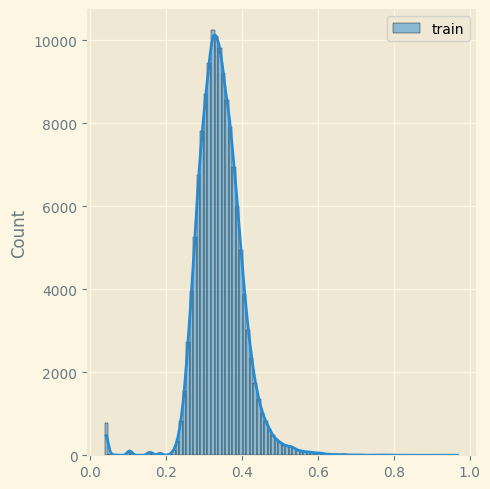

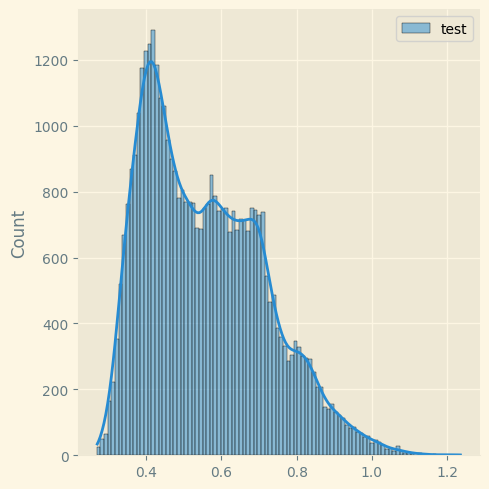

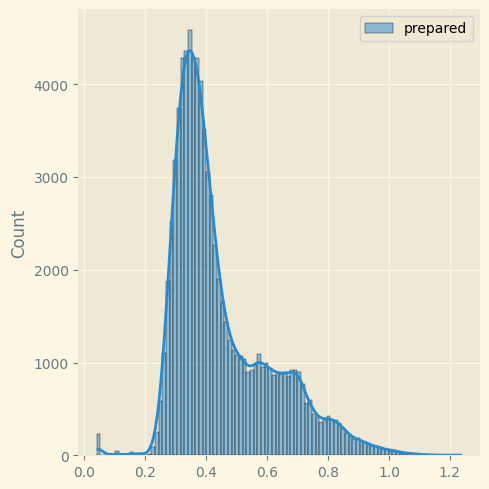

In [169]:
sns.displot(np.mean(cost_train, axis=1), bins=100, kde=True, label="train")
plt.legend()
sns.displot(np.mean(cost_test, axis=1), bins=100, kde=True, label="test")
plt.legend()
sns.displot(np.mean(cost_test_mixed, axis=1), bins=100, kde=True, label="prepared", legend=True)
plt.legend()

### PA%K Evaluation

In [172]:
# For model predictions
scores = np.mean(cost_test_mixed, axis=1)
targets = label_test_mixed.ravel()

In [173]:
result = evaluate(scores, targets, k=50)

mean_f1_wo_pa = np.mean(result["f1_scores"])
mean_f1_w_pa = np.mean(result["pa_f1_scores"])
print(f"mean F1 score without PA: {mean_f1_wo_pa} \nmean F1 score with PA: {mean_f1_w_pa}")

100%|██████████| 1659/1659 [00:37<00:00, 43.87it/s]


mean F1 score without PA: 0.6728542513906056 
mean F1 score with PA: 0.7314696304993265


In [174]:
# For model predictions with different k values
f1_wo_pa_list_trained = []
f1_w_pa_list_trained = []

f1_wo_pa_list_trained_max = []
f1_w_pa_list_trained_max = []

k_list = [i*5 for i in range(21)]
for i in k_list:
    i = i+1 if i == 0 else i

    result = evaluate(scores, targets, k=i)

    mean_f1_wo_pa = np.mean(result["f1_scores"])
    mean_f1_w_pa = np.mean(result["pa_f1_scores"])


    f1_w_pa_list_trained.append(mean_f1_w_pa)
    f1_wo_pa_list_trained.append(mean_f1_wo_pa)

    f1_wo_pa_list_trained_max.append(np.max(result["f1_scores"]))
    f1_w_pa_list_trained_max.append(np.max(result["pa_f1_scores"]))

100%|██████████| 1659/1659 [00:36<00:00, 45.14it/s]


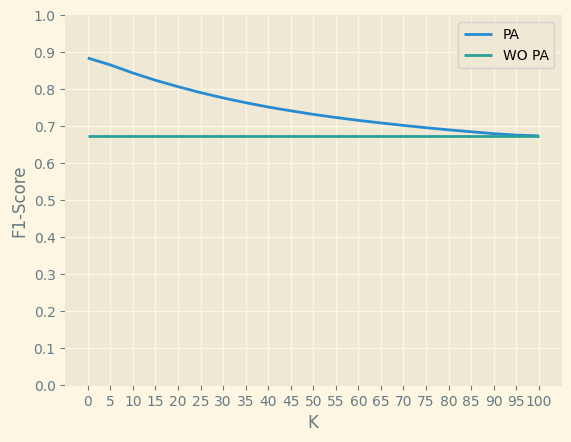

In [175]:
# MEAN F1-SCORE

plt.plot(f1_w_pa_list_trained, label="PA")
plt.plot(f1_wo_pa_list_trained, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()

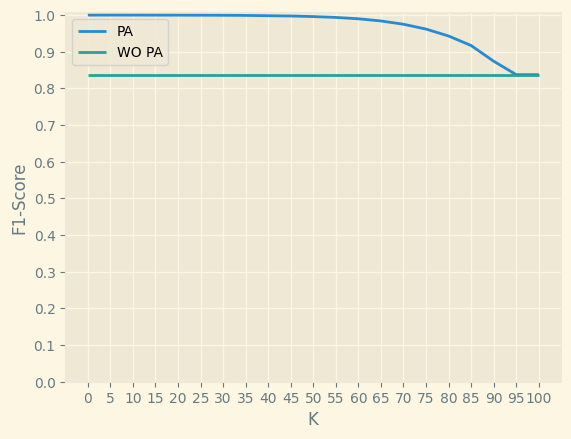

In [176]:
# BEST F1-SCORE

plt.plot(f1_w_pa_list_trained_max, label="PA")
plt.plot(f1_wo_pa_list_trained_max, label="WO PA")
plt.xticks(ticks=[i for i in range(21)],labels=k_list)
plt.yticks(ticks=[i*0.1 for i in range(11)])
plt.xlabel("K")
plt.ylabel("F1-Score")
plt.legend()